here we run some baselines to understand the level of performance to beat
we use nested CV and grid search to get realistic performance estimates

In [1]:
from netCDF4 import Dataset
from collections import defaultdict, namedtuple
import datetime
import numpy as np
import itertools
import seaborn as sns
sns.set()
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import math
import time
import os
import csv
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.utils import shuffle
from sklearn import metrics
from hkfold import HKFold, train_test_split
from scipy.optimize import fmin_cg, fmin_ncg
from IPython.display import clear_output

In [2]:
def read_df(dframe_path='data/cabauw/processed.csv.gz'):
    try:
        df = pd.read_csv(dframe_path, na_values='--')
    except UnicodeDecodeError:
        df = pd.read_csv(dframe_path, na_values='--', compression='gzip')


    df = df[(df.ustar > 0.1) & (abs(df.H) > 10) & (df.wind > 1)]
    df = df[(df.ds != 201603) & (df.phi_m.notnull())]
    df = df.sort_values(['ds', 'tt'])
    df = df.dropna()

    return df

df = read_df()

In [3]:
fd = df[df.z > 10]

lets start with a baseline. data doesnt follow the functions given in the literature, so while I fix it we can change those functions to fit the data. given the definition of $\phi_m$ for $\xi>0$:

$$
\phi_m(\xi)=a+b\xi
$$

whose derivatives are trivial. for $\xi<0$ we have

$$
\phi_m(\xi)=a(1-c^2\xi)^d
$$

where we square $c$ to make sure the base of the power is always positive. its derivatives are

$$
{\frac{\partial \phi_m}{\partial a}}\rvert_{\xi<0}=(1-c^2\xi)^d
$$

$$
\frac{\partial \phi_m}{\partial c}=-2acd\xi(1-c^2\xi)^{d-1}
$$

$$
\frac{\partial \phi_m}{\partial d}=a(1-c^2\xi)^d\ln(1-c^2\xi)
$$

considering the usual least squares with l2 regularization we have the loss function

$$
E=\frac{1}{N}\sum_i(\hat\phi_m(\xi_i)-\phi_m(\xi_i,p))^2+\frac{\lambda}{2}\sum_p p^2
$$

and its derivative with respect to the parameter $p$

$$
\frac{\partial E}{\partial p}=\frac{2}{N}\sum_i\frac{\partial}{\partial p}\phi_m(\xi_i,p)\cdot(\hat\phi_m(\xi_i)-\phi_m(\xi_i,p))+\lambda p
$$

In [4]:
class MOSTEstimator:
    ''' estimator for the universal functions in the monin-obukhov similarity theory
        implementing scikit's interface
        
        fitting is done by minimizing the L2 regularized squared error
        via conjugate gradient
    '''
    def __init__(self, regu=0.1, use_hessian=True):
        self.regu = regu
        self.a, self.b, self.c, self.d = (1, 4.8, np.sqrt(19.3), -0.25)
        self.use_hessian = use_hessian
        self.symbols = None

    def _lazy_init_hessian(self):
        # we initialize these functions lazily so that we can pickle
        # this object and send it around before fitting
        if self.use_hessian and self.symbols is None:
            a, b, c, d, x = sp.symbols('a b c d x')
            self.symbols = a, b, c, d

            self._neg_H_fn = self._get_hessian_functions(
                a * sp.Pow(1 - x * c**2, d), x, a, b, c, d
            )
            self._pos_H_fn = self._get_hessian_functions(
                a + b * x, x, a, b, c, d
            )

    @staticmethod
    def _get_hessian_functions(expr, x, *symbols):
        # returns functions computing second-order partial derivatives
        # of expr. keyed by differentiation variables
        return {
            (s1, s2): sp.lambdify(
                (x, *symbols),
                sp.simplify(sp.diff(sp.diff(expr, s1), s2)),
                'numpy'
            ) for s1 in symbols for s2 in symbols
        }

    def get_params(self, deep=True):
        return {'regu': self.regu}

    def set_params(self, regu):
        self.regu = regu
        return self

    @staticmethod
    def _compute_phi(zL, a, b, c, d):
        mask = zL >= 0
        yy = np.zeros(len(zL))
        yy[mask] = a + b * zL[mask]
        yy[~mask] = a * np.power(1 - c**2 * zL[~mask], d)
        assert all(np.isfinite(zL))
        assert all(np.isfinite(yy)), (a, b, c, d)
        return yy

    @staticmethod
    def _compute_phi_prime(zL, a, b, c, d):
        dpda, dpdb, dpdc, dpdd = np.zeros((4, len(zL)))

        pos, neg = zL >= 0, zL < 0

        dpda[pos] = 1
        dpdb[pos] = zL[pos]

        inner = 1 - c**2 * zL[neg]
        dpda[neg] = np.power(inner, d)
        dpdc[neg] = -2 * zL[neg] * a * c * d * np.power(inner, d - 1)
        dpdd[neg] = a * np.log(inner) * np.power(inner, d)

        return dpda, dpdb, dpdc, dpdd

    def _fmin_hess(self, params, xx, yy, regu):
        self._lazy_init_hessian()

        preds = self._compute_phi(xx, *params)
        xpos_mask = xx >= 0
        hh1 = np.zeros((4, 4))

        for i, s1 in enumerate(self.symbols):
            for j, s2 in enumerate(self.symbols):
                # when xx >= 0 the function is linear
                # its hessian is always 0

                neg = self._neg_H_fn[s1, s2](xx[~xpos_mask], *params)
                hh1[i, j] = np.sum((preds[~xpos_mask] - yy[~xpos_mask]) * neg)

        hh2 = np.zeros((4, len(xx)))
        hh2[:, :] = self._compute_phi_prime(xx, *params)
        
        hess = 2 * ((hh2.dot(hh2.T) + hh1) / len(xx) + regu * np.eye(4))
        return hess

    @staticmethod
    def _fmin_target(params, xx, yy, regu):
        preds = MOSTEstimator._compute_phi(xx, *params)
        err = np.mean((yy - preds)**2) + regu * sum(p**2 for p in params)
        return err

    @staticmethod
    def _fmin_grad(params, xx, yy, regu):
        preds = MOSTEstimator._compute_phi(xx, *params)
        der = MOSTEstimator._compute_phi_prime(xx, *params)

        grads = [
            2 * np.mean((preds - yy) * parpr) + 2 * regu * par
            for par, parpr in zip(params, der)
        ]

        return np.array(grads)

    def fit(self, X, y):
        if self.use_hessian:
            self.a, self.b, self.c, self.d = fmin_ncg(
                self._fmin_target,
                (self.a, self.b, self.c, self.d),
                self._fmin_grad,
                fhess=self._fmin_hess,
                args=(X, y, self.regu),
                disp=False,
            )
        else:
            self.a, self.b, self.c, self.d = fmin_cg(
                self._fmin_target,
                (self.a, self.b, self.c, self.d),
                self._fmin_grad,
                args=(X, y, self.regu),
                disp=False,
            )
        
        return self

    def predict(self, X):
        return self._compute_phi(X, self.a, self.b, self.c, self.d)

    def score(self, X, y):
        preds = self.predict(X)
        return metrics.mean_squared_error(y, preds)

In [5]:
class AttributeKFold:
    ''' k-fold cross validator splitting on a particular attribute
        so that all samples with a given value are either in the train or test set

        attribute value for each sample is given in the constructor, so that
        the attribute itself need not be in the features for the model
    '''
    def __init__(self, cv, attr):
        self.cv, self.attr = cv, attr

    def get_n_splits(self, *args, **kwargs):
        return self.cv.get_n_splits(*args, **kwargs)

    def split(self, X, y=None, groups=None):
        vals = self.attr.unique()
        for train_idx, test_idx in self.cv.split(vals):
            train_mask = self.attr.isin(vals[train_idx])
            test_mask = self.attr.isin(vals[test_idx])

            yield (
                np.argwhere(train_mask).reshape(-1),
                np.argwhere(test_mask).reshape(-1),
            )

In [6]:
def test_attributekfold():
    outer_cv = AttributeKFold(KFold(10, shuffle=True), df.ds)
    outer_train, outer_test = np.zeros((2, len(df)))
    for outer_train_idx, outer_test_idx in outer_cv.split(df):

        outer_train[outer_train_idx] += 1
        outer_test[outer_test_idx] += 1

        inner_train, inner_test = np.zeros((2, len(outer_train_idx)))
        inner_cv = AttributeKFold(KFold(5, shuffle=True), df.iloc[outer_train_idx].ds)
        for inner_train_idx, inner_test_idx in inner_cv.split(df.iloc[outer_train_idx]):
            inner_train[inner_train_idx] += 1
            inner_test[inner_test_idx] += 1

        assert all(inner_train == 4)
        assert all(inner_test == 1)

    assert all(outer_train == 9)
    assert all(outer_test == 1)

In [7]:
def plot_preds(ypred, ytrue):
    minn = max(min(ypred), min(ytrue))
    maxx = min(max(ypred), max(ytrue))
    
    plt.scatter(ytrue, ypred, s=2)
    plt.plot([minn, maxx], [minn, maxx], 'r--')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    
    plt.show()

In [14]:
def get_train_test(df, features, target, train_idx, test_idx, normalize):
    train_x, train_y = df.iloc[train_idx][features], df.iloc[train_idx][target]
    test_x, test_y = df.iloc[test_idx][features], df.iloc[test_idx][target]

    if normalize:
        mean_x, std_x = train_x.mean(), train_x.std()
        train_x = (train_x - mean_x) / std_x
        test_x = (test_x - mean_x) / std_x

        mean_y, std_y = train_y.mean(), train_y.std()
        train_y = (train_y - mean_y) / std_y
        test_y = (test_y - mean_y) / std_y
    else:
        mean_y, std_y = 0, 1

    return train_x, train_y, test_x, test_y, mean_y, std_y


def nested_cv(df, model, grid, features, target, n_jobs=7, normalize=True):
    outer_cv = AttributeKFold(KFold(10, shuffle=True), df.ds)

    results = []
    for oi, (train_idx, test_idx) in enumerate(outer_cv.split(df.ds)):
        
        train_x, train_y, test_x, test_y, mean_y, std_y = get_train_test(
            df, features, target, train_idx, test_idx, normalize
        )
        
        # grid search for best params
        inner_cv = AttributeKFold(KFold(5, shuffle=True), df.iloc[train_idx].ds)
        gs = GridSearchCV(
            model, grid, n_jobs=n_jobs, cv=inner_cv,
            scoring='neg_mean_squared_error',
            verbose=2,
        )
        gs.fit(train_x, train_y)
        
        # evaluate on test data
        y_pred = gs.best_estimator_.predict(test_x)
        y_pred = y_pred * std_y + mean_y
        test_y = test_y * std_y + mean_y

        results.append((
            metrics.explained_variance_score(test_y, y_pred),
            metrics.mean_absolute_error(test_y, y_pred),
            metrics.mean_squared_error(test_y, y_pred),
            metrics.median_absolute_error(test_y, y_pred),
            metrics.r2_score(test_y, y_pred),
            np.mean(np.abs((test_y - y_pred) / test_y)) * 100,
        ))
        
    clear_output()

    return pd.DataFrame(results, columns=[
        'explained_variance_score',
        'mean_absolute_error',
        'mean_squared_error',
        'median_absolute_error',
        'r2_score',
        'mean_percent_error'
    ]), test_x, test_y, y_pred

In [15]:
def get_cv_fold(fold, cv_k, seed, attr):
    cv = AttributeKFold(
        KFold(cv_k, shuffle=True, random_state=seed),
        attr
    ).split(attr)
    for _ in range(fold):
        _ = next(cv)
    return next(cv)


def inner_train(df_bcast, model, features, target, params, folds, keys, outer_seed, inner_seed, normalize):
    df = df_bcast.value
    
    outer_fold, inner_fold = folds
    outer_train_idx, outer_test_idx = get_cv_fold(
        outer_fold, 10, outer_seed, df.ds
    )
    
    inner_train_idx, inner_test_idx = get_cv_fold(
        inner_fold, 5, inner_seed, df.iloc[outer_train_idx].ds
    )

    # get training and test samples
    train_idx, test_idx = outer_train_idx[inner_train_idx], outer_train_idx[inner_test_idx]
    train_x, train_y, test_x, test_y, mean_y, std_y = get_train_test(
        df, features, target, train_idx, test_idx, normalize
    )

    # fit and evaluate
    model = model.set_params(**dict(zip(keys, params)))
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    y_pred = y_pred * std_y + mean_y
    test_y = test_y * std_y + mean_y
    mse = metrics.mean_squared_error(test_y, y_pred)

    return (outer_fold, params), mse


def outer_train(df_bcast, model, features, target, outer_fold, params, keys, outer_seed, normalize):
    df = df_bcast.value
    
    train_idx, test_idx = get_cv_fold(
        outer_fold, 10, outer_seed, df.ds
    )
    
    train_x, train_y, test_x, test_y, mean_y, std_y = get_train_test(
        df, features, target, train_idx, test_idx, normalize
    )

    # fit and evaluate
    model = model.set_params(**dict(zip(keys, params)))
    model.fit(train_x, train_y)
    y_pred = model.predict(test_x)
    y_pred = y_pred * std_y + mean_y
    test_y = test_y * std_y + mean_y

    return ((
        metrics.explained_variance_score(test_y, y_pred),
        metrics.mean_absolute_error(test_y, y_pred),
        metrics.mean_squared_error(test_y, y_pred),
        metrics.median_absolute_error(test_y, y_pred),
        metrics.r2_score(test_y, y_pred),
        np.mean(np.abs((test_y - y_pred) / test_y)) * 100,
    ), (test_x, test_y, y_pred) if outer_fold == 0 else None)


def nested_cv_spark(df, model, grid, features, target, normalize=True):
    import findspark
    findspark.init()

    from pyspark import SparkContext, SparkConf

    sc = SparkContext(conf=SparkConf()
        .setMaster('local[7]')
        .set('spark.driver.memory', '14g')
        .set('spark.driver.maxResultSize', '14g'))

    inner_seed, outer_seed = np.random.randint(2**32, size=2)
    grid_vals = list(itertools.product(*grid.values()))
    cv_vals = list(itertools.product(range(10), range(5)))

    df_bcast = sc.broadcast(df)

    try:
        results = (sc.parallelize(grid_vals, len(grid_vals))
             .cartesian(sc.parallelize(cv_vals, len(cv_vals)))
             .map(lambda x: inner_train(
                 df_bcast, model, features, target, x[0], x[1],
                 grid.keys(), outer_seed, inner_seed, normalize
             ))
             .reduceByKey(lambda mse1, mse2: mse1 + mse2)
             .map(lambda x: (x[0][0], (x[0][1], x[1])))
             .reduceByKey(lambda x, y: x if x[1] < y[1] else y)
             .map(lambda x: outer_train(
                 df_bcast, model, features, target, x[0], x[1][0],
                 grid.keys(), outer_seed, normalize
             ))
             .collect())
    finally:
        sc.stop()

    scores, preds = zip(*results)
    scores_df = pd.DataFrame(list(scores), columns=[
        'explained_variance_score',
        'mean_absolute_error',
        'mean_squared_error',
        'median_absolute_error',
        'r2_score',
        'mean_percent_error'
    ])

    test_x, test_y, y_pred = [ps for ps in preds if ps is not None][0]

    return scores_df, test_x, test_y, y_pred

In [16]:
features = [
    'dewpoint', 'spec_hum', 'rel_hum', 'press', 'rain',
    'air_dens', 'wind', 'temp', 'virtual_temp', 'soil_temp', 'z',
]

target = 'phi_m'

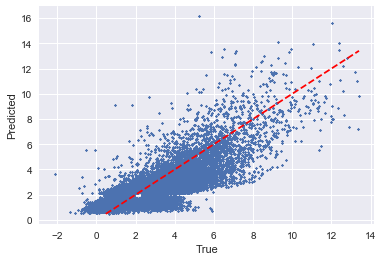

,explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error,r2_score,mean_percent_error
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.497096,0.945505,1.349293,0.814394,0.496068,164.529628
std,0.046892,0.019610,0.060906,0.026095,0.047433,63.697189
min,0.438958,0.902983,1.222589,0.772243,0.436770,93.294561
25%,0.453752,0.934137,1.321876,0.796563,0.452561,128.805061
50%,0.492940,0.952869,1.344037,0.814530,0.492894,144.919897
75%,0.527907,0.954853,1.394744,0.830624,0.525808,176.544635
max,0.572436,0.971610,1.432396,0.853091,0.572247,323.959937


In [17]:
most_res, testx, testy, ypred = nested_cv(df, MOSTEstimator(), {
    'regu': [0, 1e-2, 1e-1, 1, 1e1, 1e2]
}, 'zL', target, normalize=False)
plot_preds(ypred, testy)
most_res.describe()

it is so bad because of data at z=2 and z=10

In [18]:
fd = df[df.z > 10]
est = MOSTEstimator(0.1).fit(fd.zL, fd.phi_m)

mse 0.44596009060031816


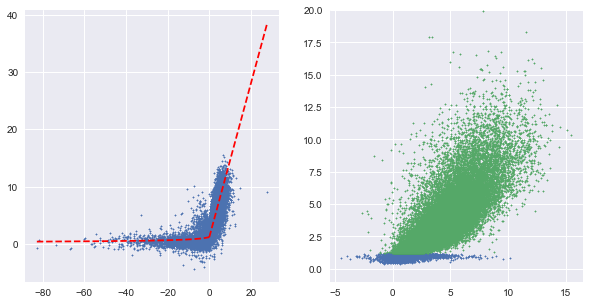

In [19]:
xneg = fd.zL[fd.zL < 0].sort_values()
pneg = est.a * np.power(1 - est.c**2 * xneg, est.d)

xpos = fd.zL[fd.zL >= 0].sort_values()
ppos = est.a + est.b * xpos

print('mse', np.mean((fd.phi_m - pneg)**2))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(fd.zL, fd.phi_m, s=1)
plt.plot(xneg, pneg, 'r--')
plt.plot(xpos, ppos, 'r--')
plt.subplot(1, 2, 2)
plt.scatter(fd[fd.zL < 0].sort_values('zL').phi_m, pneg, s=1)
plt.scatter(fd[fd.zL >= 0].sort_values('zL').phi_m, ppos, s=1)
plt.ylim(-1, 20)
plt.show()

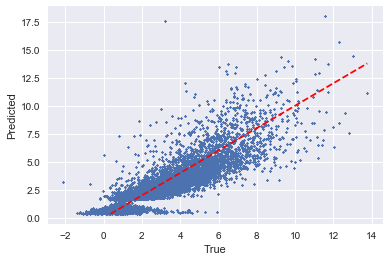

,explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error,r2_score,mean_percent_error
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.773193,0.583846,0.767598,0.416219,0.772664,166.719783
std,0.017052,0.026950,0.091711,0.021542,0.016993,56.201172
min,0.747992,0.551236,0.650188,0.389326,0.747992,91.658894
25%,0.759894,0.563324,0.693044,0.402694,0.758221,119.844286
50%,0.776729,0.581496,0.761290,0.414838,0.776277,162.199142
75%,0.783502,0.596902,0.799714,0.424508,0.783295,206.532470
max,0.802026,0.634549,0.920323,0.462990,0.800844,260.688770


In [20]:
most_res, testx, testy, ypred = nested_cv(fd, MOSTEstimator(), {
    'regu': [0, 1e-2, 1e-1, 1, 1e1, 1e2]
}, 'zL', target, normalize=False)
plot_preds(ypred, testy)
most_res.describe()

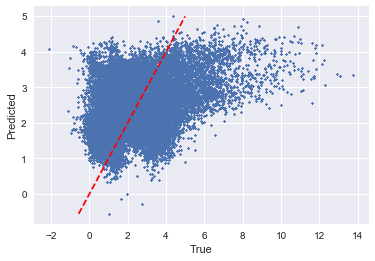

,explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error,r2_score,mean_percent_error
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.042247,1.162840,2.563548,0.974101,0.036502,293.408618
std,0.468270,0.036574,1.121531,0.034696,0.470704,171.821899
min,-1.284202,1.097527,1.806694,0.929813,-1.297172,138.719643
25%,0.180221,1.136826,2.181539,0.943922,0.175567,215.296242
50%,0.206149,1.162005,2.266583,0.973378,0.197858,245.683812
75%,0.211348,1.192198,2.387540,0.997136,0.206184,308.676253
max,0.227789,1.213117,5.714707,1.031319,0.225188,735.641625


In [21]:
most_res, testx, testy, ypred = nested_cv(df, Ridge(), {
    'alpha': [0, 1e-2, 1e-1, 1, 1e1, 1e2]
}, features, target)
plot_preds(ypred, testy)
most_res.describe()

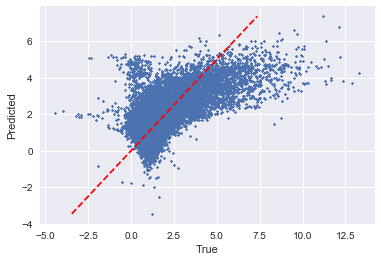

,explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error,r2_score,mean_percent_error
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.201115,1.035950,2.709269,0.743339,0.193603,438.104389
std,0.587606,0.088872,1.915749,0.088187,0.589933,202.120275
min,-1.464445,0.919032,1.545824,0.632910,-1.477317,193.819053
25%,0.359797,0.973872,1.873950,0.679193,0.356874,277.237187
50%,0.373364,1.022749,2.201825,0.712434,0.365848,374.575869
75%,0.410527,1.106444,2.507800,0.812818,0.409886,595.632389
max,0.488779,1.169699,8.065427,0.879004,0.478812,737.643802


In [22]:
most_res, testx, testy, ypred = nested_cv(fd, Ridge(), {
    'alpha': [0, 1e-2, 1e-1, 1, 1e1, 1e2]
}, features, target)
plot_preds(ypred, testy)
most_res.describe()

In [ ]:
knn_res, testx, testy, ypred = nested_cv(KNeighborsRegressor(),  {
    'n_neighbors': [1, 5, 10],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}, features, target)
plot_preds(ypred, testy)
knn_res

In [ ]:
rf_res, testx, testy, ypred = nested_cv(RandomForestRegressor(),  {
    'n_estimators': [100],
    'max_features': [3, 5, 11],
    'min_samples_split': [10, 100, 500, 1000],
    'min_samples_leaf': [10, 100, 500, 1000],
}, features, target)
plot_preds(ypred, testy)
rf_res